In [1]:
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from matplotlib.mlab import PCA as mlabPCA
from sklearn import preprocessing
from sklearn.decomposition import PCA 
import math
import warnings

# Display preferences.
%matplotlib inline
#pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [10]:
# Read in the crime data for Florida for 2016, listed by city
florida_crime = pd.read_excel('./florida_2016.xls')
florida_crime.columns = ['City', 'Population', 'Violent Crime', 'Murder', 'Rape', 'Robbery',
       'Assault', 'Property Crime', 'Burglary', 'Larceny-theft',
       'Motor Vehicle Theft', 'Arson']
florida_crime.set_index('City', inplace=True)

In [11]:
florida_crime.head()

,Population,Violent Crime,Murder,Rape,Robbery,Assault,Property Crime,Burglary,Larceny-theft,Motor Vehicle Theft,Arson
City,,,,,,,,,,,
Alachua,9900,42,0,6,4,32,306,64,219,23,1
Altamonte Springs,43499,152,8,16,35,93,1535,274,1185,76,4
Apalachicola,2291,4,0,0,0,4,26,6,10,10,0
Apopka,49796,224,1,28,39,156,2008,478,1400,130,6
Arcadia,7893,64,1,1,7,55,189,101,81,7,0


In [12]:
florida_crime.describe()

,Population,Violent Crime,Murder,Rape,Robbery,Assault,Property Crime,Burglary,Larceny-theft,Motor Vehicle Theft,Arson
count,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000
mean,34807.492958,177.957746,2.436620,13.855634,48.545775,113.119718,1184.700704,194.750000,895.186620,94.764085,2.989437
std,73543.953812,486.837924,9.149689,39.400323,144.790679,303.056794,2795.544937,498.894018,2053.082453,264.172120,8.084135
min,92.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3954.500000,8.000000,0.000000,0.000000,1.000000,6.000000,93.000000,17.000000,66.750000,5.000000,0.000000
50%,12512.000000,42.000000,0.000000,3.000000,7.000000,26.000000,347.500000,59.000000,260.000000,18.000000,1.000000
75%,38386.750000,136.750000,2.000000,13.000000,32.000000,93.250000,1139.500000,173.000000,905.750000,77.500000,2.250000
max,880557.000000,5504.000000,106.000000,517.000000,1463.000000,3418.000000,31538.000000,5851.000000,22660.000000,3027.000000,83.000000


/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


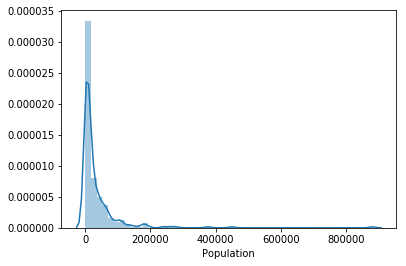

In [13]:
sns.distplot(florida_crime.Population)

In [169]:
# Log-transform the population variable
X = florida_crime.loc[:, ~florida_crime.columns.isin(['Population','Property Crime'])]
X["Log Population"] = np.log(florida_crime.Population)
y = florida_crime["Property Crime"]

X["Population_low"] = (florida_crime.Population < 3955).values
X["Population_medium"] = (florida_crime.Population <= 12512).values
X["Population_medium_high"] = (florida_crime.Population < 79472).values
X["Population_high"] = (florida_crime.Population >= 79472).values

X_2017["Population_low"] = (florida_crime_2017.Population < 3955).values
X_2017["Population_medium"] = (florida_crime_2017.Population <= 12512).values
X_2017["Population_medium_high"] = (florida_crime_2017.Population < 79472).values
X_2017["Population_high"] = (florida_crime_2017.Population >= 79472).values

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [155]:
X.corr()

,Violent Crime,Murder,Rape,Robbery,Assault,Burglary,Larceny-theft,Motor Vehicle Theft,Arson,Population_low,Population_medium,Population_high,Log Population,Population_medium_high
Violent Crime,1.000000,0.916978,0.893219,0.975464,0.996568,0.953686,0.961277,0.972806,0.893976,-0.203451,-0.321508,0.573448,0.534123,-0.573448
Murder,0.916978,1.000000,0.849622,0.863262,0.919967,0.936081,0.869960,0.893257,0.797951,-0.150462,-0.240561,0.456230,0.426851,-0.456230
Rape,0.893219,0.849622,1.000000,0.814050,0.890302,0.936060,0.896968,0.894967,0.760974,-0.197809,-0.313609,0.571868,0.507238,-0.571868
Robbery,0.975464,0.863262,0.814050,1.000000,0.957345,0.907444,0.948380,0.962424,0.876829,-0.189641,-0.306640,0.579294,0.517095,-0.579294
Assault,0.996568,0.919967,0.890302,0.957345,1.000000,0.948519,0.948234,0.959602,0.894159,-0.205965,-0.321941,0.556310,0.532144,-0.556310
Burglary,0.953686,0.936081,0.936060,0.907444,0.948519,1.000000,0.957751,0.961979,0.824676,-0.211128,-0.333274,0.592958,0.543398,-0.592958
Larceny-theft,0.961277,0.869960,0.896968,0.948380,0.948234,0.957751,1.000000,0.982438,0.859677,-0.241345,-0.381290,0.664152,0.601136,-0.664152
Motor Vehicle Theft,0.972806,0.893257,0.894967,0.962424,0.959602,0.961979,0.982438,1.000000,0.860836,-0.198592,-0.324771,0.622864,0.541061,-0.622864
Arson,0.893976,0.797951,0.760974,0.876829,0.894159,0.824676,0.859677,0.860836,1.000000,-0.206822,-0.324192,0.572518,0.524585,-0.572518
Population_low,-0.203451,-0.150462,-0.197809,-0.189641,-0.205965,-0.211128,-0.241345,-0.198592,-0.206822,1.000000,0.577350,-0.194701,-0.741113,0.194701


In [159]:
# Because all of the crime variables are colinear, lets create some components!
# Now PCA all features (crimes)
# not trying to reduce dimensionality just want to eliminate collinearity
pca = PCA(n_components=1)
pca.fit(X.iloc[:,:9].values)
X_new = pca.transform(X.iloc[:,:9].values)
X_new = pd.DataFrame(X_new, columns=["Crime_PCA"])
X_new["Log_Population"] = X["Log Population"].values
X_new["Population_low"] = X["Population_low"].values
X_new["Population_medium"] = X["Population_medium"].values
X_new["Population_medium_high"] = X["Population_medium_high"].values
X_new["Population_high"] = X["Population_high"].values
X_new["Property_Crime"] = y.values

In [160]:
X_new.head()

,Crime_PCA,Log_Population,Population_low,Population_medium,Population_medium_high,Population_high,Property_Crime
0,-710.791605,9.200290,False,True,True,False,306
1,276.521808,10.680493,False,False,True,False,1535
2,-932.213583,7.736744,True,True,True,False,26
3,552.297514,10.815690,False,False,True,False,2008
4,-825.505241,8.973732,False,True,True,False,189


In [161]:
X_new.corr()

,Crime_PCA,Log_Population,Population_low,Population_medium,Population_medium_high,Population_high,Property_Crime
Crime_PCA,1.000000,0.595560,-0.237756,-0.375732,-0.656653,0.656653,0.999247
Log_Population,0.595560,1.000000,-0.741113,-0.818916,-0.567092,0.567092,0.589585
Population_low,-0.237756,-0.741113,1.000000,0.577350,0.194701,-0.194701,-0.233691
Population_medium,-0.375732,-0.818916,0.577350,1.000000,0.337232,-0.337232,-0.370190
Population_medium_high,-0.656653,-0.567092,0.194701,0.337232,1.000000,-1.000000,-0.652440
Population_high,0.656653,0.567092,-0.194701,-0.337232,-1.000000,1.000000,0.652440
Property_Crime,0.999247,0.589585,-0.233691,-0.370190,-0.652440,0.652440,1.000000


In [52]:
# So the population_medium_high might be where the model fails the most...lets look!

array([[  42,    0,    6, ...,  219,   23,    1],
       [ 152,    8,   16, ..., 1185,   76,    4],
       [   4,    0,    0, ...,   10,   10,    0],
       ...,
       [ 100,    2,   12, ...,  766,   53,    2],
       [  54,    0,    6, ...,  347,   19,    0],
       [  51,    1,    7, ...,  772,   21,    5]])

In [163]:
formula1 = ("Property_Crime ~ Log_Population + Crime_PCA "
+ "+ Population_low + Population_medium + Population_medium_high  + Population_high")
# Fit the model to our data using the formula.
lm1 = smf.ols(formula=formula1, data=X_new).fit()
print("Model Parameters\n===========================================")
print(lm1.params)
print("p-values\n===========================================")
print(lm1.pvalues)
print("\n\nR-Squared: {}".format(lm1.rsquared))

Model Parameters
Intercept                         875.215593
Population_low[T.True]            -11.393908
Population_medium[T.True]           5.995870
Population_medium_high[T.True]    455.896662
Population_high[T.True]           419.318931
Log_Population                    -15.182814
Crime_PCA                           1.279585
dtype: float64
p-values
Intercept                         9.265608e-18
Population_low[T.True]            6.545482e-01
Population_medium[T.True]         8.030080e-01
Population_medium_high[T.True]    4.101442e-23
Population_high[T.True]           2.250705e-12
Log_Population                    2.482536e-01
Crime_PCA                         0.000000e+00
dtype: float64


R-Squared: 0.9985533559555255


The above p-values tell us that there is weak evidence that coefficients for Population_low and Population_medium are non-zero.

In [165]:
formula_new = "Property_Crime ~ Log_Population + Crime_PCA + Population_medium_high  + Population_high"
# Fit the model to our data using the formula.
lm_new = smf.ols(formula=formula_new, data=X_new).fit()
print("Model Parameters\n===========================================")
print(lm_new.params)
print("p-values\n===========================================")
print(lm_new.pvalues)
print("\n\nR-Squared: {}".format(lm_new.rsquared))

Model Parameters
Intercept                         866.129111
Population_medium_high[T.True]    452.625241
Population_high[T.True]           413.503870
Log_Population                    -13.825634
Crime_PCA                           1.279287
dtype: float64
p-values
Intercept                         4.538955e-66
Population_medium_high[T.True]    1.561012e-75
Population_high[T.True]           1.748765e-35
Log_Population                    1.288621e-02
Crime_PCA                         0.000000e+00
dtype: float64


R-Squared: 0.998551583334995


In [166]:
y_hat_new = lm_new.predict(X_new)

In [168]:
# Let us use this model to predict the 2017 property crime
florida_crime_2017 = pd.read_excel('./florida_2017.xls')
florida_crime_2017.columns = ['City', 'Population', 'Violent Crime', 'Murder', 'Rape', 'Robbery',
       'Assault', 'Property Crime', 'Burglary', 'Larceny-theft',
       'Motor Vehicle Theft', 'Arson']
florida_crime_2017.set_index('City', inplace=True)
# Log-transform the population variable
X_2017 = florida_crime.loc[:, ~florida_crime_2017.columns.isin(['Population','Property Crime'])]
X_2017["Log Population"] = np.log(florida_crime_2017.Population)
y_2017 = florida_crime_2017["Property Crime"]

0       282.248352
1      1524.840398
2        19.220645
3      1875.767376
4       138.629051
5       318.868799
6        50.194935
7       536.160169
8      2158.217319
9       102.216654
10      893.056354
11       24.786725
12       90.048051
13       34.400885
14       51.277877
15      933.409958
16       84.989852
17      199.068356
18       74.093773
19       45.082814
20     2356.080738
21       65.577560
22     3639.703902
23     1771.899542
24       36.560009
25      312.093855
26      110.825552
27     2926.403254
28       20.735323
29     1111.273488
          ...     
254     256.301401
255     720.201494
256      39.409415
257    1681.614059
258     275.423648
259      16.293284
260      69.353692
261      69.633768
262     350.530396
263     415.509313
264     536.168671
265      44.811926
266     105.591438
267      29.035132
268     999.573138
269     551.099938
270      84.116571
271     298.419688
272    5533.341093
273     454.125645
274      48.471072
275     187.

In [170]:
pca2 = PCA(n_components=1)
pca.fit(X_2017.iloc[:,:9].values)
X_new_2017 = pca.transform(X_2017.iloc[:,:9].values)
X_new_2017 = pd.DataFrame(X_new_2017, columns=["Crime_PCA"])
X_new_2017["Log_Population"] = X_2017["Log Population"].values
X_new_2017["Property_Crime"] = y_2017.values
X_new_2017["Population_low"] = X_2017["Population_low"].values
X_new_2017["Population_medium"] = X_2017["Population_medium"].values
X_new_2017["Population_medium_high"] = X_2017["Population_medium_high"].values
X_new_2017["Population_high"] = X_2017["Population_high"].values

In [171]:
X_new_2017.head()

,Crime_PCA,Log_Population,Property_Crime,Population_low,Population_medium,Population_medium_high,Population_high
0,-710.791605,9.214034,266,False,True,True,False
1,276.521808,10.688142,1369,False,False,True,False
2,-932.213583,7.760041,5,True,True,True,False
3,552.297514,10.836301,1881,False,False,True,False
4,-825.505241,8.986196,175,False,True,True,False


In [172]:
y_hat_2017 = lm_new.predict(X_new_2017)
y_hat_2017.index = florida_crime.index

In [187]:
resids_2017 = pd.DataFrame(y_2017.values - y_hat_2017.values, columns=["residual"])
resids_2017["City"] = florida_crime_2017.index
resids_2017.set_index('City', inplace=True)

In [188]:
resids_2017.head()

,residual
City,
Alachua,-16.058339
Altamonte Springs,-155.734646
Apalachicola,-13.898549
Apopka,5.517586
Arcadia,36.543282


So our model failed to predict any property crime for 8 cities.

In [190]:
resids_2017.residual.dropna().mean()

-68.61600947764606

In [198]:
florida_crime.loc["Treasure Island",:]

Population             6925
Violent Crime            27
Murder                    0
Rape                      3
Robbery                   5
Assault                  19
Property Crime          259
Burglary                 28
Larceny-theft           225
Motor Vehicle Theft       6
Arson                     2
Population_group          1
Population_low            0
Population_medium         1
Population_high           0
Name: Treasure Island, dtype: object

In [209]:
y_hat_2017

City
Alachua                  282.058339
Altamonte Springs       1524.734646
Apalachicola              18.898549
Apopka                  1875.482414
Arcadia                  138.456718
Atlantic Beach           318.573674
Atlantis                  50.097731
Auburndale               535.676252
Aventura                2158.206411
Bal Harbour Village      101.492061
Bartow                   892.656482
Bay Harbor Islands        24.941280
Belle Glade               89.941765
Belle Isle                34.273380
Belleair                  51.166827
Belleair Beach           932.767814
Belleair Bluffs           84.713490
Belleview                198.747509
Biscayne Park             74.200766
Blountstown               45.060666
Boca Raton              2355.631114
Bowling Green             65.634573
Boynton Beach           3639.393875
Bradenton               1771.578805
Bradenton Beach           36.330940
Brooksville              311.805666
Bunnell                  110.614176
Cape Coral             